# Importing modules and data


## Importing all modules

### Warning: if you have an error message: "ImportError: No module named [module name]", please go to your command line and launch command: pip install [module name]

In [1]:
# module to get current directory folder
import os
import sys

# module to import global parameters from JSON file
import json

# module for progress bars
from tqdm.notebook import tqdm

# date and time manipulation
import datetime as dt
import pytz
tz = pytz.timezone("Etc/GMT")

# data manipulation
import numpy as np
import pandas as pd
from itertools import compress

# technical (financial) indicators 
import ta  

# modules for data preprocessing
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

# pytorch machine learning models
import torch
import torch.autograd as autograd
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim

# plotting module
import matplotlib.pyplot as plt

## Importing sentiment of tweets dataset and price dataset

In [2]:
# getting bitcoin's price data
with open(os.path.join(sys.path[0],"data/binance_BTCUSDT_1m.csv")) as fp:
    raw_bitcoin_data = pd.read_csv(fp)
    
# converting string of date &time to python datetime
raw_bitcoin_data['time']=raw_bitcoin_data['time'].apply(lambda utc: tz.localize(dt.datetime.utcfromtimestamp(utc)))

# getting sentiment analysis of every tweets in tweets csv
with open(os.path.join(sys.path[0],"data/sentiments.csv")) as fp:
    raw_sentiment_data = pd.read_csv(fp)
    
# converting string of date & time to python datetime
raw_sentiment_data['time'] = pd.to_datetime(raw_sentiment_data['time'],errors='coerce')

# removing errors (file isn't always well formated)
raw_sentiment_data.dropna(inplace=True)

## Function to initialize dataframe with wanted features and labels

In [3]:
# main function that preprocesses the data to single dataframe
def initialize(raw_sentiment, raw_prices, time_int,rsi_window):
    
    # grouping values by time invertval and computing: 
        # opening value (getting opening value of first element)
        # highest value (getting max in interval)
        # lowest value (getting min in interval)
        # close value (getting closing value of last element)
        # volume (summing all volume exchanged in interval)
    bitcoin_data = raw_prices.groupby(pd.Grouper(key='time',freq=f"{time_int}")).agg({
        "open": "first",
        "high":"max",
        "low":"min", 
        "close": "last", 
        "volume": "sum"
    })
    
    # calculating rsi index
    bitcoin_data['rsi'] = ta.momentum.RSIIndicator(close=bitcoin_data.close, window=rsi_window).rsi()
    
    # calculating variation in time interval
    bitcoin_var = (bitcoin_data['open']-bitcoin_data['close'])/bitcoin_data['open']
    
    # applying classification: 1: variation > 0, 0: variation =< 0
    bitcoin_class = bitcoin_var.apply(lambda x: 1 if x>0 else 0)
    
    # generating batch of the sentiment of tweets per time interval
    tweets_per_int = raw_sentiment.groupby(pd.Grouper(key='time',freq=f"{time_int}"))
    
    # getting mean polarity scores for each time interval
    polarity_scores = tweets_per_int.mean()
    
    # creating final dataset
    df = pd.DataFrame(polarity_scores)
    
    # computing number of tweets per time interval
    df['tweets'] = tweets_per_int.neg.count()
    
    # adding price and indicators data to final dataframe
    df[bitcoin_data.columns] = bitcoin_data
    
    # adding label (price going up or down)
    df['label']= bitcoin_class
    
    # dropping unwanted columns
    df.drop(["Unnamed: 0",'neu','compound','open','high','low'],inplace=True, axis=1)
    
    # reseting index from date & time to numbers
    df.reset_index(inplace=True,drop=True)
    
    # converting missing data (in format: NaN): 
        # negativity and positivity to 0
        # closing, volume and rsi to last values
    df.fillna({'neg':0,'pos':0},inplace=True)
    df.close.ffill(inplace=True)
    df.volume.ffill(inplace=True)
    df.rsi.ffill(inplace=True)
    ####### TROUVER MOYEN POUR NE PAS AVOIR DE SAUT DANS LE TEMPS: GROUPER PREND TOUTES LES VALUES
    
    return df

## Getting data ready for LSTM Classifier

### Defining Dataset class

In [4]:
# creating class dataset (needed for dataloader method)
class Dataset(Dataset):
    
    # init method
    def __init__(self,X,y):
        self.X = X
        self.y = y
        self.len = X.shape[0]
        
    # get item method to get specific item of dataset
    def __getitem__(self,idx):
        return self.X[idx],self.y[idx]
    
    # len method to get length of dataset
    def __len__(self):
        return self.len

### Function to create sequences (a feature set will have sequences)

In [5]:
# function to create sequences from dataframe (LSTM treats sequences as input)
def create_sequences(input_data: pd.DataFrame, target_column, sequence_length):
    
    # getting size of data
    data_size = len(input_data)
    
    sequences =[]
    
    # getting features and label for every element:
        # we get all features (polarity scores + price + indicators) of last x values and label for next line 
        # => we do not predict with data we will not have 
    for i in range(data_size-sequence_length):
        
        X_i = torch.Tensor(input_data.drop(target_column,axis=1).iloc[i:i+sequence_length].to_numpy())
        
        y_i = torch.Tensor([input_data.iloc[i+sequence_length][target_column]])
        
        sequences.append((X_i,y_i))
        
    # unpacking features and labels to different vectors
    X = [sequence[0] for sequence in sequences]
    y = [sequence[1] for sequence in sequences]
    
    return torch.stack(X),torch.stack(y)

### Function to create dataloader object (that creates batches of data) from initial dataframe

In [6]:
# function that converts initial dataframe to format it in an acceptable way to machine learning module  
def df2loader(df,val_proportion,test_proportion, sequence_size, batch_size):

    # getting index corresponding to validation and test proportion
    train_idx = int(len(df)*(1-(val_proportion + test_proportion)))
    val_idx = int(len(df)*(1-test_proportion))

    # splitting main df into train, validation and test df
    train_df = df.iloc[:train_idx]
    val_df = df.iloc[train_idx + 1 : val_idx]
    test_df = df.iloc[val_idx + 1 : ]

    # setting scaler to normalize features between 0 and 1 (this is used for faster convergence)
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler = scaler.fit(train_df)

    # applying scaling to dataframes
    train_df = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns)
    val_df = pd.DataFrame(scaler.transform(val_df), columns=val_df.columns)
    test_df = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)

    # getting sequences of data for train, val and test datasets
    X_train,y_train = create_sequences(train_df, 'label', sequence_size)
    X_val,y_val = create_sequences(val_df, 'label', sequence_size)
    X_test,y_test = create_sequences(test_df, 'label', sequence_size)

    # setting dataset as classes (needed for dataloader)
    train_data = Dataset(X_train,y_train)
    val_data = Dataset(X_val,y_val)
    test_data = Dataset(X_test,y_test)
    
    # creating dataloaders for train and test datasets (getting data in batches)
    train_loader = DataLoader(train_data,batch_size=batch_size)
    val_loader = DataLoader(val_data,batch_size=batch_size)
    test_loader = DataLoader(test_data,batch_size=batch_size)
    
    return train_loader, val_loader, test_loader

## Machine learning Model 

In [7]:
# setting model as class (standard way of doing it)
class LSTMClassifier(nn.Module):
    # init method
    def __init__(self, input_size, hidden_size,sequence_size,num_layers,dropout):
        
        # calling super constructor
        super(LSTMClassifier,self).__init__()

        # initializing all classes variables
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sequence_size = sequence_size
        self.num_layers=num_layers
        self.droput = dropout
        
        # creating the LSTM cell of specified dimensions and characteristics
        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2)

        # dimension reduction: we want the hidden state to be reducted to single output 
        self.linear = nn.Linear(in_features=hidden_size, out_features=1)

        # sigmoid function so that output is between 0 and 1 (classification)
        self.sigmoid = nn.Sigmoid()

    # forward method to set 
    def forward(self, x):
        
        # applying input of LSTM cells to get output and hidden states
        lstm_out, self.hidden = self.lstm(x)
        
        # getting output between 0 and 1 from last hidden state output of LSTM netword
        y_pred = self.sigmoid(self.linear(lstm_out[:,-1,:]))

        return y_pred
  

In [8]:
def accuracy(y_prob,label):
    y_pred = [i>0.5 for i in y_prob]
    return sum([i==j for(i,j) in zip(y_pred,label)])/len(y_prob)

In [9]:
# function to get accuracy for samples that have a sigificant trend to be taken into account
def threashold_accuracy(y_pred_list, label_list, threashold_value):
    
    # initializing accuracy for all batches
    acc = []
    
    # initializing count of total samples and number above threashold (in absolute value)
    samples_count = 0
    notable_count = 0
    
    # iterating over all batches of samples
    for batch in range(len(y_pred_list)):
        
        # adding number of samples
        samples_count += len(y_pred_list[batch])
        
        # getting indices where predictions are above threashold (in absolute value)
        idx = abs(y_pred_list[batch]-0.5) > threashold_value
        
        # counting number of samples above threashold
        notable_count += sum(idx)
        
        if sum(idx)!= 0:
            
            # getting notable predictions and the true labels 
            notable_preds = list(compress(y_pred_list[batch],idx))
            notable_labels = list(compress(label_list[batch],idx))
            
            # computing batch accuracy for notable predictions and appending to global accuracy
            batch_acc = accuracy(notable_preds,notable_labels)
            acc.append(batch_acc)
            
    if len(acc) != 0:
        # getting mean accuracy over batch
        mean_acc = sum(acc)/len(acc)
        
    else:
        # if no values above threashold
        mean_acc = 0
    
    # computing number 
    prop_notable = notable_count/samples_count
    
    return mean_acc, prop_notable

In [10]:
def launchML(train_dataloader, val_dataloader, input_size, hidden_size, num_layers, dropout, sequence_size,learning_rate, num_epochs, threashold_value):

### INITIALIZATION ###

    # initializing the model with correct dimensions
    model = LSTMClassifier(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        sequence_size=sequence_size,
        dropout=dropout)
    
    # setting criterion for loss function as Binary Cross Entropy (BCE)
    criterion = nn.BCELoss()

    # setting optimizer to ADAM with chosen learning rate 
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
    

    # initializing loss, accuracy (simple + threasholded) and proportions of threaholded values in training and validating
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    thd_train_acc_list = []
    thd_val_acc_list = []
    train_prop_notable_list = []
    val_prop_notable_list = []

    # iterating along the number of epochs
    for epoch in tqdm(range(num_epochs)):
        
        # initialize the predictions and labels for current epoch for training and testing
        train_preds = []
        train_labels = []
        val_preds = []
        val_labels = []
    
        # initialize loss and (simple) accuracy for current epoch
        train_loss = 0
        val_loss = 0
        train_acc = []
        val_acc = []
        

### TRAINING ###
        
        # getting model in training mode
        model.train()

        # iterating over all batches of data
        for i,train_data in enumerate(train_dataloader):
            
            # getting model's predictions
            y_pred = model(train_data[:][0].view(-1,sequence_size,input_size))

            # resetting gradients to zero
            optimizer.zero_grad()

            # calculating loss 
            loss = criterion(y_pred,train_data[:][1])

            # backward
            loss.backward()

            # updating weights and biases of model
            optimizer.step()
            
            # adding preds and labels of current batch
            train_preds.append(y_pred)
            train_labels.append(train_data[:][1])

            # adding loss of current batch
            train_loss+=loss.item()

            # adding accuracy of current batch
            train_acc.append(accuracy(y_pred,train_data[:][1]).item())
            
            

### VALIDATING ###
        
        # getting model in evaluation mode
        model.eval()

        # iterating over all batches of data
        for j, val_data in enumerate(val_dataloader):

            # getting model's predictions
            y_pred = model(val_data[:][0].view(-1,sequence_size,input_size))

            # calculating loss 
            loss = criterion(y_pred,val_data[:][1])

            # adding loss of current batch
            val_loss+=loss.item()
            
            # adding preds and labels of current batch
            val_preds.append(y_pred)
            val_labels.append(val_data[:][1])

            # adding accuracy of current batch
            val_acc.append(accuracy(y_pred,val_data[:][1]).item())
            
        # getting global loss normalized over number of iterations of current epoch for training and testing
        train_loss /= i
        val_loss /=j
    
        # getting global accuracy of current epoch for training and testing
        train_acc_epoch = sum(train_acc)/len(train_acc)
        val_acc_epoch = sum(val_acc)/len(val_acc)
        
        # calculating threasholded accuracy for training and testing
        thd_train_acc_batch, train_prop_notable_batch = threashold_accuracy(y_pred_list=train_preds, label_list=train_labels, threashold_value=threashold_value)
        thd_val_acc_batch, val_prop_notable_batch = threashold_accuracy(y_pred_list=val_preds, label_list=val_labels, threashold_value=threashold_value)

        # adding loss, accuracy (simple + threasholded) and proportions of threaholded values of current epoch to history
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        train_acc_list.append(train_acc_epoch)
        val_acc_list.append(val_acc_epoch)
        thd_train_acc_list.append(thd_train_acc_batch)
        thd_val_acc_list.append(thd_val_acc_batch)
        train_prop_notable_list.append(train_prop_notable_batch.item())
        val_prop_notable_list.append(val_prop_notable_batch.item())
        
        # adding current model parameters to history
        torch.save({
            'epoch':epoch, 
            'model': model, 
            'model_state_dict': model.state_dict, 
            'train_preds':train_preds, 
            'train_labels': train_labels,
            'val_preds': val_preds, 
            'val_labels': val_labels,
        },os.path.join(sys.path[0],f"pytorch_models/epoch-{epoch}.pt"))
        
        # printing current status every 10%
        if (num_epochs>10):
            if epoch  % int(num_epochs/10) == 0:
                print(f"Epoch: {epoch}\nTrain loss: {train_loss}\tTrain accuracy:{train_acc_epoch}\nVal loss: {val_loss}\tVal accuracy:{val_acc_epoch}\n-----")
        else:
            print(f"Epoch: {epoch}\nTrain loss: {train_loss}\tTrain accuracy:{train_acc_epoch}\nVal loss: {val_loss}\tVal accuracy:{val_acc_epoch}\n-----")
    return [train_loss_list, val_loss_list, train_acc_list, val_acc_list, thd_train_acc_list, thd_val_acc_list, train_prop_notable_list, val_prop_notable_list]

### Results formatting

In [11]:
# function to show graphs
def results(train_loss, val_loss, train_acc, val_acc, train_thd_acc, val_thd_acc, train_prop, val_prop):
    
    # getting the actual date in string format (for saving files)
    now = dt.datetime.strftime(dt.datetime.now(), "%Y-%m-%d,%Hh%M") 
    
    # getting number of epochs
    epochs = range(len(train_loss))
    
### PLOTTING LOSS ###
    
    # setting figure size
    plt.figure(figsize=(16,8))
    
    # plotting train and val loss
    plt.plot(epochs, train_loss, label='Train loss',lw=0.5)
    plt.plot(epochs, val_loss, label='Val loss',lw=0.5)
    
    # setting labels, legend and title
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss function')
    
    # saving figure
    plt.savefig(os.path.join(sys.path[0],f"plots/loss[{now}].png"))
    
    # showing figure
    plt.show()
    
### PLOTTING SIMPLE ACCURACY ###
    
    # setting figure size
    plt.figure(figsize=(16,8))
    
    # plotting train and val simple accuracy
    plt.plot(epochs, train_acc, label='Train accuracy',lw=0.5)
    plt.plot(epochs, val_acc, label='Val accuracy',lw=0.5)
    
    # adding 0.5 line (validation must be higher)
    plt.axhline(y=0.5, color='r', linestyle='-',lw=0.5)
    
    # setting labels, legend and title
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Simple accuracy')
    
    # saving figure
    plt.savefig(os.path.join(sys.path[0],f"plots/accuracy_simple[{now}].png"))
    
    # showing figure
    plt.show()
    
### PLOTTING ACCURACY WITH THREASHOLD ###
    
    # setting figure size
    plt.figure(figsize=(16,8))
    
    # plotting train and val accuracy with threashold
    plt.plot(epochs, train_thd_acc, label='Train accuracy',lw=0.5)
    plt.plot(epochs, val_thd_acc, label='Val accuracy',lw=0.5)
    
    # adding 0.5 line (validation must be higher)
    plt.axhline(y=0.5, color='r', linestyle='-',lw=0.5)
    
    # setting labels, legend and title
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy with threashold')
    plt.legend()
    plt.title('Accuracy for values with threashold')
    
    # saving figure
    plt.savefig(os.path.join(sys.path[0],f"plots/accuracy_thd[{now}].png"))
    
    # showing figure
    plt.show()
    
### PLOTTING PROPORTION ###
    
    # setting figure size
    plt.figure(figsize=(16,8))
    
    # plotting train and val proportion of notable samples
    plt.plot(epochs, train_prop, label='Train accuracy',lw=0.5)
    plt.plot(epochs, val_prop, label='Val accuracy',lw=0.5)
    
    
    # setting labels, legend and title
    plt.xlabel('Epochs')
    plt.ylabel('Proportion of notable points')
    plt.legend()
    plt.title('Proportion of values that are out of threashold ')
    
    # saving figure
    plt.savefig(os.path.join(sys.path[0],f"plots/prop_notable[{now}].png"))
    
    # showing figure
    plt.show()

### Model chooser and testing

In [12]:
def tester(test_dataloader,threashold_value,best_epoch):
    
    # loading optimal model
    checkpoint = torch.load(os.path.join(sys.path[0],f"pytorch_models/epoch-{best_epoch}.pt"))
    opt_model = checkpoint['model']
    
    # getting  loss function 
    criterion = nn.BCELoss()
    
    # getting model in evaluation mode
    opt_model.eval()
    
    # initializing predictions and labels
    y_pred_list = []
    label_list = []
    
    # initializing test loss and accuracy
    test_loss = 0
    test_acc = []
    
    # iterating over all batches of data
    for i, test_data in enumerate(test_dataloader):
        
        y_pred = opt_model(test_data[:][0].view(-1,opt_model.sequence_size,opt_model.input_size))

        # calculating loss 
        loss = criterion(y_pred,test_data[:][1])

        # adding loss of current batch
        test_loss+=loss.item()

        # adding accuracy of current batch
        test_acc.append(accuracy(y_pred,test_data[:][1]).item())
        
        # adding predictions and labels
        y_pred_list.append(y_pred)
        label_list.append(test_data[:][1])
    
    # getting global loss normalized over number of iterations 
    test_loss /= i
        
    # getting global accuracy  
    test_acc = sum(test_acc)/len(test_acc)
    
    # getting threasholded accuracy
    thd_test_acc, test_prop_notable = threashold_accuracy(y_pred_list, label_list, threashold_value)
    
    print(f"Test loss: {test_loss}\tTest accuracy:{test_acc}\t Test threashold accuracy:{thd_test_acc}\t Proportion notable:{test_prop_notable.item()}")
    
    # saving trained model
    torch.save(opt_model,os.path.join(sys.path[0],"pytorch_models/pretrained_model.pt"))
    
    return test_loss, test_acc, thd_test_acc, test_prop_notable.item()

In [13]:
def saver(best_epoch, parameters, hist_data,test_res):
    # loading optimal model values
    checkpoint = torch.load(os.path.join(sys.path[0],f"pytorch_models/epoch-{best_epoch}.pt"))
                            
    # adding all values of simulation to array
    sim_values = []
    sim_values.append(dt.datetime.now())
    sim_values.extend(parameters)
    sim_values.extend([i[best_epoch] for i in hist_data])
    sim_values.extend(test_res)
    out = pd.DataFrame(sim_values).transpose()
    out.columns = ['date','TIME_INT','RSI_WINDOW','NUM_FEATURES','VAL_PROP','TEST_PROP','SEQUENCE_SIZE','BATCH_SIZE','NUM_EPOCHS','LEARNING_RATE','HIDDEN_SIZE','NUM_LAYERS','DROPOUT','THREASHOLD_VALUE','train_loss','val_loss','train_acc','val_acc','thd_train_acc','thd_val_acc','train_prop_notable','val_prop_notable','test_loss','test_acc','thd_test_acc','test_prop_notable']
    out.to_csv(os.path.join(sys.path[0],"data/results.csv"))

## Parameters

In [14]:
# all changeable parameters are displayed here

## data engineering parameters ##

# opening global parameters file
with open(os.path.join(sys.path[0],'parameters.json')) as fp:
    parameters = json.load(fp)

# getting global parameters
TIME_INT = parameters['TIME_INT'] # time interval
RSI_WINDOW = int(parameters['RSI_WINDOW']) # time window for RSI calulcations


VAL_PROP = 0.15 # proportion of the data that will be in the validation set
TEST_PROP = 0.15 # proportion of the data that will be in the validation set

## machine learning model hyperparameters

NUM_FEATURES = 6 # number of features (number of columns-1 of the dataframe)
SEQUENCE_SIZE = 60 # number of elements to be in sequence 
BATCH_SIZE = 256 # batch size for faster computation of ML model

LEARNING_RATE = 0.001 # step used for optimization
HIDDEN_SIZE = 50 # number of
NUM_LAYERS = 4 # number of 
DROPOUT = 0.2 #

NUM_EPOCHS = 20 #number of epochs

## parameter for accuracy (can be changed after ML)
THREASHOLD_VALUE = 0.1 # value of the threashold for the variation to be described as going up or down (in percent)

# putting all parameters in a list
PARAMETERS = [TIME_INT,RSI_WINDOW,NUM_FEATURES,VAL_PROP,TEST_PROP,SEQUENCE_SIZE,BATCH_SIZE,NUM_EPOCHS,LEARNING_RATE,HIDDEN_SIZE,NUM_LAYERS,DROPOUT,THREASHOLD_VALUE]

## Launching all functions

### Initializing and showing dataframe

In [15]:
df = initialize(raw_sentiment=raw_sentiment_data, raw_prices=raw_bitcoin_data, time_int=TIME_INT,rsi_window=RSI_WINDOW)

In [16]:
df

,neg,pos,tweets,close,volume,rsi,label
0,0.033350,0.142500,40,8658.04,1231.175651,63.820385,0
1,0.087240,0.096200,25,8697.05,864.959636,66.473540,0
2,0.059143,0.140743,35,8774.34,1852.387309,70.911263,0
3,0.051313,0.067094,64,9319.98,5437.443127,85.317402,0
4,0.043784,0.093647,116,9112.06,4796.268405,71.207396,1
...,...,...,...,...,...,...,...
70267,0.032890,0.104724,145,49150.01,356.445982,51.148846,1
70268,0.053222,0.103321,162,49309.66,368.766161,52.803518,0
70269,0.073361,0.106158,133,49552.84,568.209092,55.228914,0
70270,0.045615,0.096391,156,49653.58,335.077288,56.207803,0


### Getting data in dataloader (ready for ML model)

In [17]:
train_dataloader, val_dataloader, test_dataloader = df2loader(df,val_proportion=VAL_PROP,test_proportion=TEST_PROP, sequence_size=SEQUENCE_SIZE, batch_size=BATCH_SIZE)

### Launching model training

In [18]:
hist_data = launchML(train_dataloader=train_dataloader,val_dataloader=val_dataloader, input_size=NUM_FEATURES, hidden_size=HIDDEN_SIZE,num_layers=NUM_LAYERS,dropout=DROPOUT, sequence_size=SEQUENCE_SIZE,learning_rate=LEARNING_RATE, num_epochs=NUM_EPOCHS,threashold_value=THREASHOLD_VALUE)

Epoch: 0
Train loss: 0.6968165339599729	Train accuracy:0.504419919103384
Val loss: 0.7105569869279862	Val accuracy:0.48304115853658536
-----
Epoch: 2
Train loss: 0.6967394717076686	Train accuracy:0.5049845377604166
Val loss: 0.710461063683033	Val accuracy:0.5169588414634146
-----
Epoch: 4
Train loss: 0.6967276169367486	Train accuracy:0.5058155550311009
Val loss: 0.7104259192943573	Val accuracy:0.5169588414634146
-----
Epoch: 6
Train loss: 0.6967183395205993	Train accuracy:0.5056101915736994
Val loss: 0.7103505939245224	Val accuracy:0.5169588414634146
-----
Epoch: 8
Train loss: 0.6967194701364527	Train accuracy:0.5057691264276704
Val loss: 0.7104554995894432	Val accuracy:0.5033091968152581
-----
Epoch: 10
Train loss: 0.6960771611223671	Train accuracy:0.5158583596348763
Val loss: 0.7089677304029465	Val accuracy:0.5278518803235961
-----
Epoch: 12
Train loss: 0.6940476732104236	Train accuracy:0.5323627178246776
Val loss: 0.7082058325409889	Val accuracy:0.5341272862946115
-----
Epoch: 14
Tr

### Plotting results

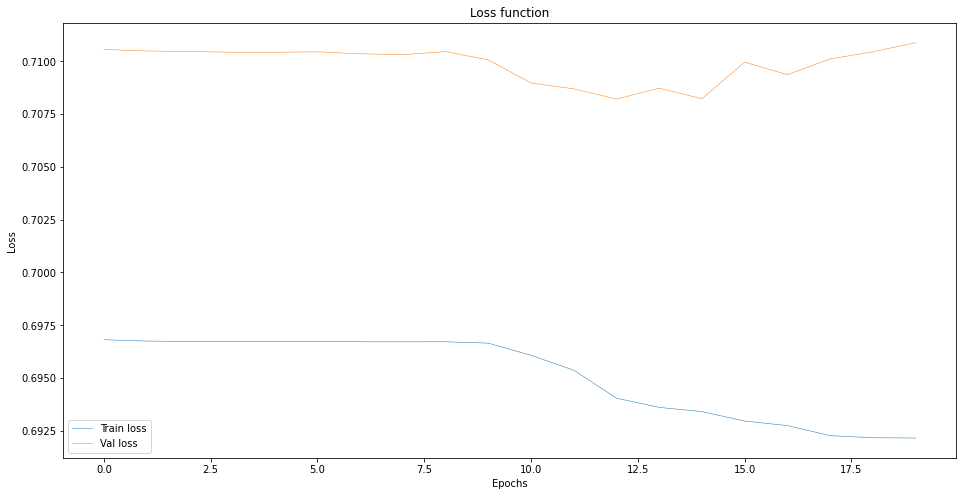

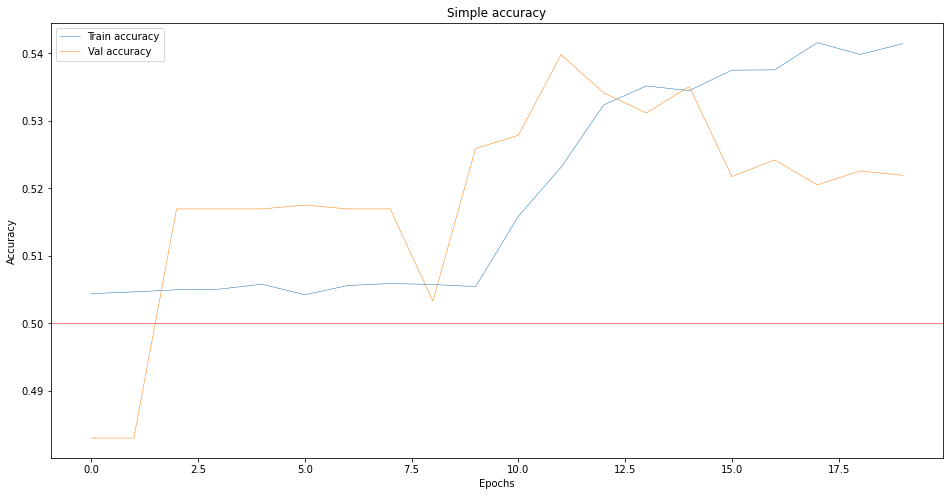

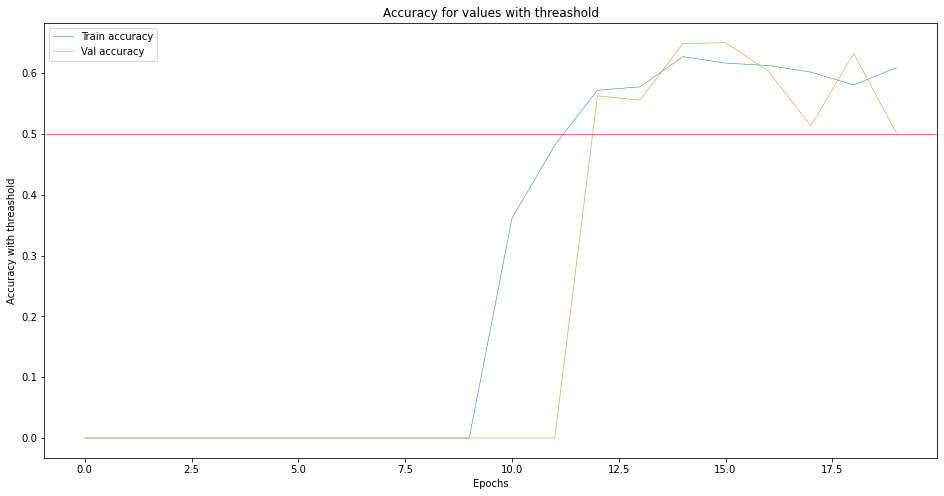

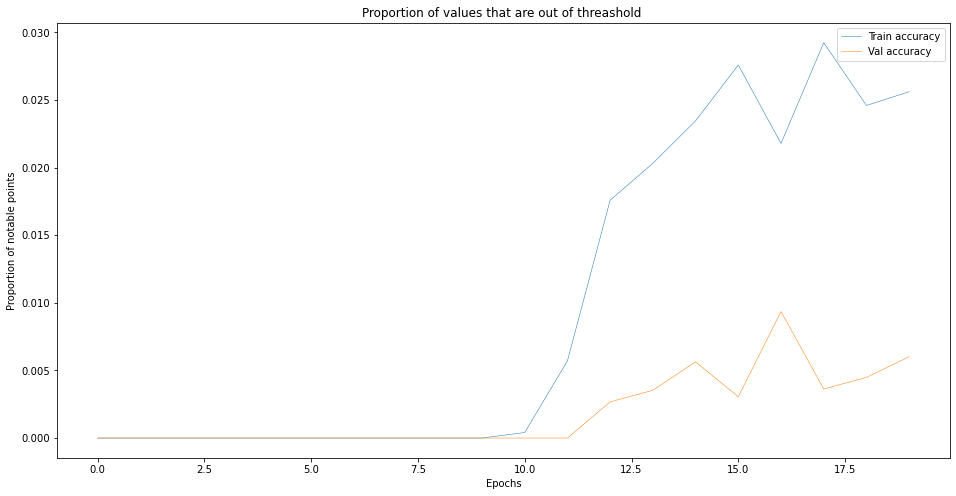

In [19]:
results(hist_data[0],hist_data[1],hist_data[2],hist_data[3],hist_data[4],hist_data[5],hist_data[6],hist_data[7])

### Testing model

In [26]:
test_res = tester(test_dataloader=test_dataloader,threashold_value=THREASHOLD_VALUE, best_epoch=13)

Test loss: 0.7112879127264022	Test accuracy:0.5039824698029495	 Test threashold accuracy:tensor([1.])	 Proportion notable:9.541984763927758e-05


In [27]:
saver(best_epoch=13, parameters=PARAMETERS, hist_data=hist_data,test_res=test_res)